In [5]:
import pickle
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal

In [50]:
# get the data from the relevant pickle file
infile = open('/home/yandex/BrainW2021/projects/ML_Ofir_Eden_Eden/Data/pickel_files/Hour7','rb')
pc_pymat = pickle.load(infile)
infile.close()
time_window_hours = 1
time_window_ms = time_window_hours * 60.0 * 60 * 1000

In [51]:
# preform fourie transform using welch  
freq_power = []
 
for i in range(360):
    single_bin = pc_pymat[i * 200000:200000*(i+1)]
    f, Pxx_den = signal.welch(single_bin, 20000, nperseg=20000, noverlap=10000, scaling='spectrum')
    freq_power.append(Pxx_den)

freq_power = np.array(freq_power)

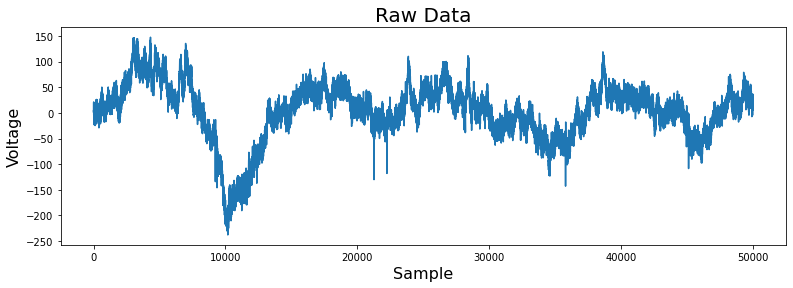

In [65]:
plt.figure(figsize=(13,4))
plt.plot(pc_pymat[:50000])
plt.title("Raw Data", fontsize=20)
plt.ylabel('Voltage', fontsize=16)
plt.xlabel('Sample', fontsize=16)
plt.show()

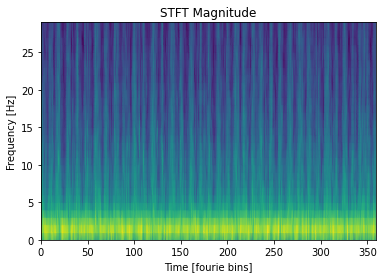

In [61]:
# plot spectogram before processing it
plt.pcolormesh([i for i in range(360)], f[:30], np.abs(np.log(np.transpose(freq_power[:,:30]))), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [fourie bins]')
plt.show()

In [53]:
# normalized spectogram data - norm power of each frequency with it's avarage power
low_freq_power = freq_power[:,:30]
avg_freq_power = np.array([0.0]*30)
# calculate avarage power of the freq
for i in range(30):
    avg_freq_power[i] = sum(low_freq_power[:,i]) / low_freq_power.shape[0]
    
# create the normalized matrix
norm_freq_power = []
for seg in low_freq_power:
    new_seg = np.array([0.0]*30)
    for i in range(30):
        new_seg[i] = seg[i] / avg_freq_power[i]
    norm_freq_power.append(new_seg)
    
norm_freq_power = np.array(norm_freq_power)

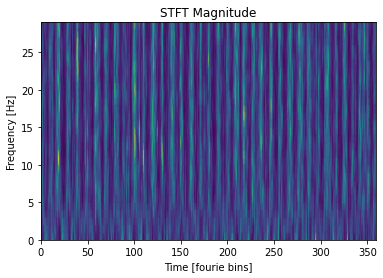

In [54]:
# segmentation and plot
plt.pcolormesh([i for i in range(360)], f[:30], np.abs((np.transpose(norm_freq_power))), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [fourie bins]')
plt.show()

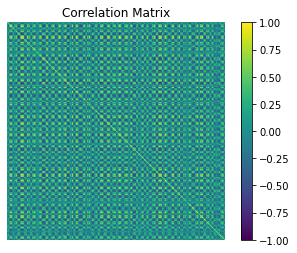

In [56]:
# create the correlation matrix
low_freq_magnitudes = np.abs(norm_freq_power)
# compute correlation matrix of frequencies magnitudes
corr_mat = np.corrcoef(low_freq_magnitudes) #by pearson
corr_mat.shape
plt.title('Correlation Matrix')
plt.axis('off')
plt.imshow(corr_mat)
plt.clim(-1,1)
plt.colorbar()

In [45]:
# cluster with ward (2 clusters)
from sklearn.cluster import AgglomerativeClustering

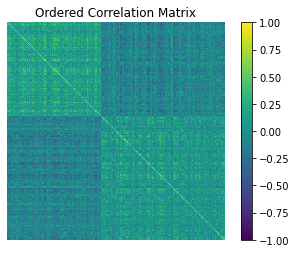

In [46]:
# re-organize the segments according to clusters
ward_clusters = AgglomerativeClustering().fit(corr_mat)
indices = np.argsort(ward_clusters.labels_)
magnitudes_by_clusters = low_freq_magnitudes[indices]
corr_mat_by_clusters = np.corrcoef(magnitudes_by_clusters)
corr_mat_by_clusters.shape

plt.title('Ordered Correlation Matrix')
plt.axis('off')
plt.imshow(corr_mat_by_clusters)
plt.clim(-1,1)
plt.colorbar()

In [47]:
# divide the data to two clusters
lables = ward_clusters.labels_
indxes_cls1 = np.where(lables == 0)[0]
indxes_cls2 = np.where(lables == 1)[0]
cls1 = low_freq_magnitudes[indxes_cls1, :]
cls2 = low_freq_magnitudes[indxes_cls2, :]

In [48]:
#cal the freqs
def avrg_freq_per_cluster(cls_group):
    cls_len = cls_group.shape[0]
    relevant_freqs = cls_group.shape[1]
    cls_freqs = [0]*relevant_freqs
    for vec in cls_group:
        for i in range(relevant_freqs):
            cls_freqs[i] += vec[i]

    cls_freqs =  np.divide(cls_freqs,cls_len)
    return cls_freqs

# plot the graph
def show_graph(cls1_freqs, cls2_freqs):
    plt.plot(f[:30],cls1_freqs)
    plt.plot(f[:30],cls2_freqs)
    plt.title('nPSD of Each Cluster as Function of the Frequency')
    plt.ylabel('nPSD')
    plt.xlabel('Frequency [Hz]')
    plt.show()

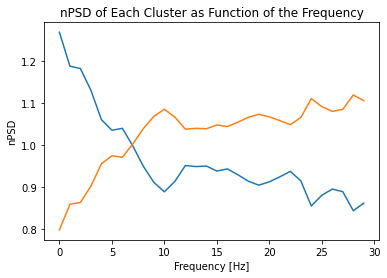

In [49]:
show_graph(avrg_freq_per_cluster(cls1), avrg_freq_per_cluster(cls2))